In [1]:
import os
import random
import shutil

In [2]:
#set paths
data_path = 'C:\\Users\\HP\\anaconda3\\envs\\Heather\\signsss'
train_path = 'C:\\Users\\HP\\anaconda3\\envs\\Heather\\Training'
val_path = 'C:\\Users\\HP\\anaconda3\\envs\\Heather\\Validation' 
test_path = 'C:\\Users\\HP\\anaconda3\\envs\\Heather\\Test'

In [3]:
#split ratios
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

In [4]:
# Ensure directories exist
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

In [5]:
# List all videos and shuffle them
videos = os.listdir(data_path) 
random.shuffle(videos)

In [6]:
# List all videos and shuffle them
videos = os.listdir(data_path) 
random.shuffle(videos)

In [7]:
# Calculate split indices
total_videos = len(videos)
train_idx = int(train_ratio * total_videos)
val_idx = int((train_ratio + val_ratio) * total_videos)

In [8]:
# Move videos to each split
for i, video in enumerate(videos):
    if i < train_idx:
        shutil.move(os.path.join(data_path, video), train_path)
    elif i < val_idx:
        shutil.move(os.path.join(data_path, video), val_path)
    else:
        shutil.move(os.path.join(data_path, video), test_path)

In [9]:
import cv2

In [10]:
def extract_frames(video_path, output_folder, interval=5):
    cap = cv2.VideoCapture(video_path)
    count = 0
    success, frame = cap.read()
    while success:
        if count % interval == 0:
            frame_filename = os.path.join(output_folder, f"{count}.jpg")
            cv2.imwrite(frame_filename, frame)
        success, frame = cap.read()
        count +=1
    cap.release

In [11]:
# Process each split
for split_folder in [train_path, val_path, test_path]:
    for video_file in os.listdir(split_folder):
        video_path = os.path.join(split_folder, video_file)
        output_folder = os.path.join(split_folder, os.path.splitext(video_file)[0])
        os.makedirs(output_folder, exist_ok=True)
        extract_frames(video_path, output_folder)

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [13]:
class FrameDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.data = []

        # Generate a mapping of labels to integers
        self.label_to_idx = {label: idx for idx, label in enumerate(os.listdir(folder_path))}
        
        # Load the data paths and corresponding integer labels
        for label_folder in os.listdir(folder_path):
            label_path = os.path.join(folder_path, label_folder)
            if os.path.isdir(label_path):  # Check if it is a directory
                for frame in os.listdir(label_path):
                    frame_path = os.path.join(label_path, frame)
                    self.data.append((frame_path, self.label_to_idx[label_folder]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        frame_path, label_idx = self.data[idx]
        image = Image.open(frame_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label_idx  # Return the integer label

In [14]:
# Define transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [15]:
# Create datasets and loaders
train_dataset = FrameDataset(train_path, transform=transform)
val_dataset = FrameDataset(val_path, transform=transform)
test_dataset = FrameDataset(test_path, transform=transform)

In [16]:
import os

print("Training path contains:", os.listdir(train_path))
print("Validation path contains:", os.listdir(val_path))
print("Testing path contains:", os.listdir(test_path))

Training path contains: ['banana', 'banana.mp4', 'bhavhudi', 'bhavhudi.mp4', 'bhururka', 'bhururka.mp4', 'chigezero', 'chigezero.mp4', 'dzihwa', 'dzihwa.mp4', 'frames', 'gumbezi', 'gumbezi.mp4', 'hunhu', 'hunhu.mp4', 'isa', 'isa.mp4', 'kacheche', 'kacheche.mp4', 'kubhururuka', 'kubhururuka.mp4', 'kubuda kweropa', 'kubuda kweropa.mp4', 'kubuda ropa', 'kubuda ropa.mp4', 'kuchengeta', 'kuchengeta.mp4', 'kuchinja', 'kuchinja.mp4', 'kudonha', 'kudonha.mp4', 'kuendesa', 'kuendesa.mp4', 'kufinyamisa chiso', 'kufinyamisa chiso.mp4', 'kuisa', 'kuisa.mp4', 'kukanga', 'kukanga.mp4', 'kukanganwa', 'kukanganwa.mp4', 'kukurumidza', 'kukurumidza.mp4', 'kumashure', 'kumashure.mp4', 'kumberi', 'kumberi.mp4', 'kunyika', 'kunyika.mp4', 'kunze', 'kunze.mp4', 'kupa mhosva', 'kupa mhosva.mp4', 'kupa zvokudya', 'kupa zvokudya.mp4', 'kupfeka kwakafanira', 'kupfeka kwakafanira.mp4', 'kupisa muviri', 'kupisa muviri.mp4', 'kupomera', 'kupomera.mp4', 'kure', 'kure.mp4', 'kuregerera', 'kuregerera.mp4', 'kuresa', '

In [17]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50
from tqdm import tqdm
import time
from torchvision import models

In [19]:
# Count the number of classes by checking the directories in train_path
num_classes = len(os.listdir(train_path))

In [20]:
# Define the model and modify the output layer to match the number of classes
model = models.resnet50(weights = 'DEFAULT')  # Use weights instead of `pretrained`
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust the output layer

In [21]:
#define 

In [22]:
# Extract features from images
def extract_features(images):
    with torch.no_grad():
        features = model.features(images)
        features = torch.flatten(features, 1)
        return features

In [23]:
# Define the optimizer with a learning rate and weight decay
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [24]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs to train the model
epochs = 10  # You can adjust this number as needed

# Check if CUDA (GPU) is available, otherwise default to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Ensure the model is moved to the correct device
model = model.to(device)

for epoch in range(epochs):
    start_time = time.time()
    model.train()
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    # Optionally print the time taken for each epoch
    elapsed_time = time.time() - start_time
    print(f'Epoch {epoch+1}/{epochs} completed in {elapsed_time:.2f} seconds') 

Epoch 1/10 completed in 331.50 seconds
Epoch 2/10 completed in 261.80 seconds
Epoch 3/10 completed in 262.85 seconds
Epoch 4/10 completed in 265.52 seconds
Epoch 5/10 completed in 271.43 seconds
Epoch 6/10 completed in 268.75 seconds
Epoch 7/10 completed in 280.43 seconds
Epoch 8/10 completed in 246.59 seconds
Epoch 9/10 completed in 260.09 seconds
Epoch 10/10 completed in 284.56 seconds


In [25]:
# Training loop
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        # Training
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        # Print results
        print(f"Epoch {epoch + 1}/{epochs}, "
              f"Train Loss: {running_loss / len(train_loader):.4f}, "
              f"Val Loss: {val_loss / len(val_loader):.4f}, "
              f"Val Acc: {100 * correct / total:.2f}%")

In [26]:
from torch.utils.data import DataLoader

In [27]:
# Train the model
train_model(model, train_loader, val_loader, epochs=5)

100%|██████████| 11/11 [04:49<00:00, 26.30s/it]


Epoch 1/5, Train Loss: 0.1621, Val Loss: 11.3633, Val Acc: 0.00%


100%|██████████| 11/11 [11:28:23<00:00, 3754.90s/it]   


Epoch 2/5, Train Loss: 0.2947, Val Loss: 10.4316, Val Acc: 0.00%


100%|██████████| 11/11 [04:05<00:00, 22.36s/it]


Epoch 3/5, Train Loss: 0.4359, Val Loss: 9.1789, Val Acc: 0.69%


100%|██████████| 11/11 [04:03<00:00, 22.10s/it]


Epoch 4/5, Train Loss: 0.1979, Val Loss: 12.0554, Val Acc: 0.00%


100%|██████████| 11/11 [04:11<00:00, 22.87s/it]


Epoch 5/5, Train Loss: 0.0768, Val Loss: 13.3453, Val Acc: 0.00%


In [28]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")

test_model(model, test_loader)

Test Accuracy: 0.00%


In [29]:
# Save the model after testing
torch.save(model.state_dict(), 'Tsakatsa.pth')

In [30]:
print("Saved Successfully")

Saved Successfully


Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


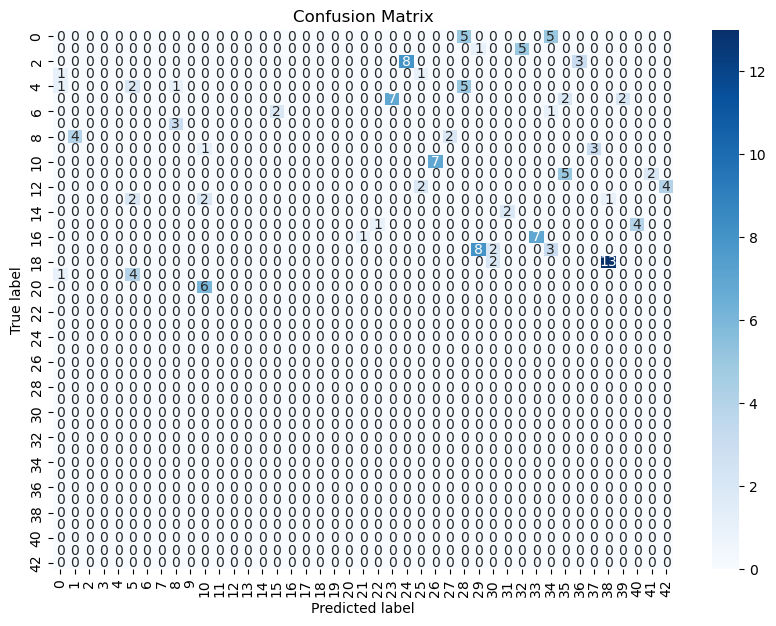

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

all_labels = []
all_predictions = []

# Collect labels and predictions during validation
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()